In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch

from A2D2Dataset import A2D2SegmentationDataset
from mask_generation import *
from train import train_model

torch.backends.cudnn.benchmark = True


In [2]:
def get_device():
  return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

get_device()

device(type='cuda')

In [3]:
%%html
<!-- Potrzebne dla poprawnego wyświetlania tqdm w VSCode https://stackoverflow.com/a/77566731 -->
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}
</style>

In [4]:
import torchvision.transforms.v2 as v2
from torchvision.transforms import InterpolationMode

# transformacje geometryczne
transforms_geo = v2.Compose([ 
    v2.RandomResizedCrop((768, 768), scale=(0.5, 2.0), interpolation=InterpolationMode.NEAREST),
    v2.RandomHorizontalFlip(p=0.5),    
])

# transformacje obrazu (nie stosowane do maski)
transforms_img = v2.Compose([
    v2.ColorJitter(0.2, 0.2, 0.2, 0.1),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# wczytanie datasetu
dataset = A2D2SegmentationDataset(
    root_dir=".\\data\\camera_lidar_semantic\\",
    scenes=None,
    camera="cam_front_center",
    with_pointcloud=False,
    with_meta=False,
    transforms_geo=transforms_geo,
    transforms_img=transforms_img
)

c:\Users\fhcar\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5528543].


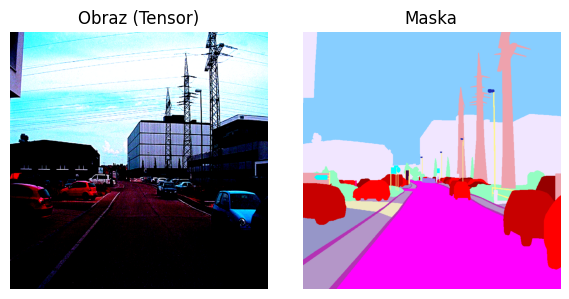

In [5]:
item = dataset[10]
image = item['image']    # Tensor [C,H,W]
label = item['label']    # LongTensor [H,W] z indeksami klas

fig, ax = plt.subplots(1, 2, figsize=(6, 3))

# obraz (permutacja [C,H,W] → [H,W,C])
img_np = image.permute(1, 2, 0).cpu().numpy()
ax[0].imshow(img_np)
ax[0].set_title("Obraz (Tensor)")
ax[0].axis("off")

# kolorowanie maski
class_id_to_rgb = {v: k for k, v in dataset.PALETTE.items()}

lbl_np = label.cpu().numpy()    # [H, W] z wartościami od 0 do (num_classes-1)
H, W = lbl_np.shape
mask_rgb = np.zeros((H, W, 3), dtype=np.uint8)

# łączenie maski
for cls_id, rgb in class_id_to_rgb.items():
    mask_rgb[lbl_np == cls_id] = rgb

ax[1].imshow(mask_rgb)
ax[1].set_title("Maska")
ax[1].axis("off")

# wyświetlenie
plt.tight_layout()
plt.show()

In [6]:
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights

device = get_device()

weights = DeepLabV3_ResNet50_Weights.DEFAULT
model = deeplabv3_resnet50(weights=weights)

train_model(
    model=model,
    dataset=dataset,
    ckpt_name="resnet50_test_2_new",
    device=device
)

Loading checkpoint 'resnet50_test_2_new'
Resuming from epoch 30


  0%|          | 0/5503 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Generowanie przykładowych obrazów
Po wytrenowaniu modelu należy wprowadzić poniżej nazwę checkpointu oraz ścieżkę do pliku `.png`, na  którym można przetestować działanie modelu.

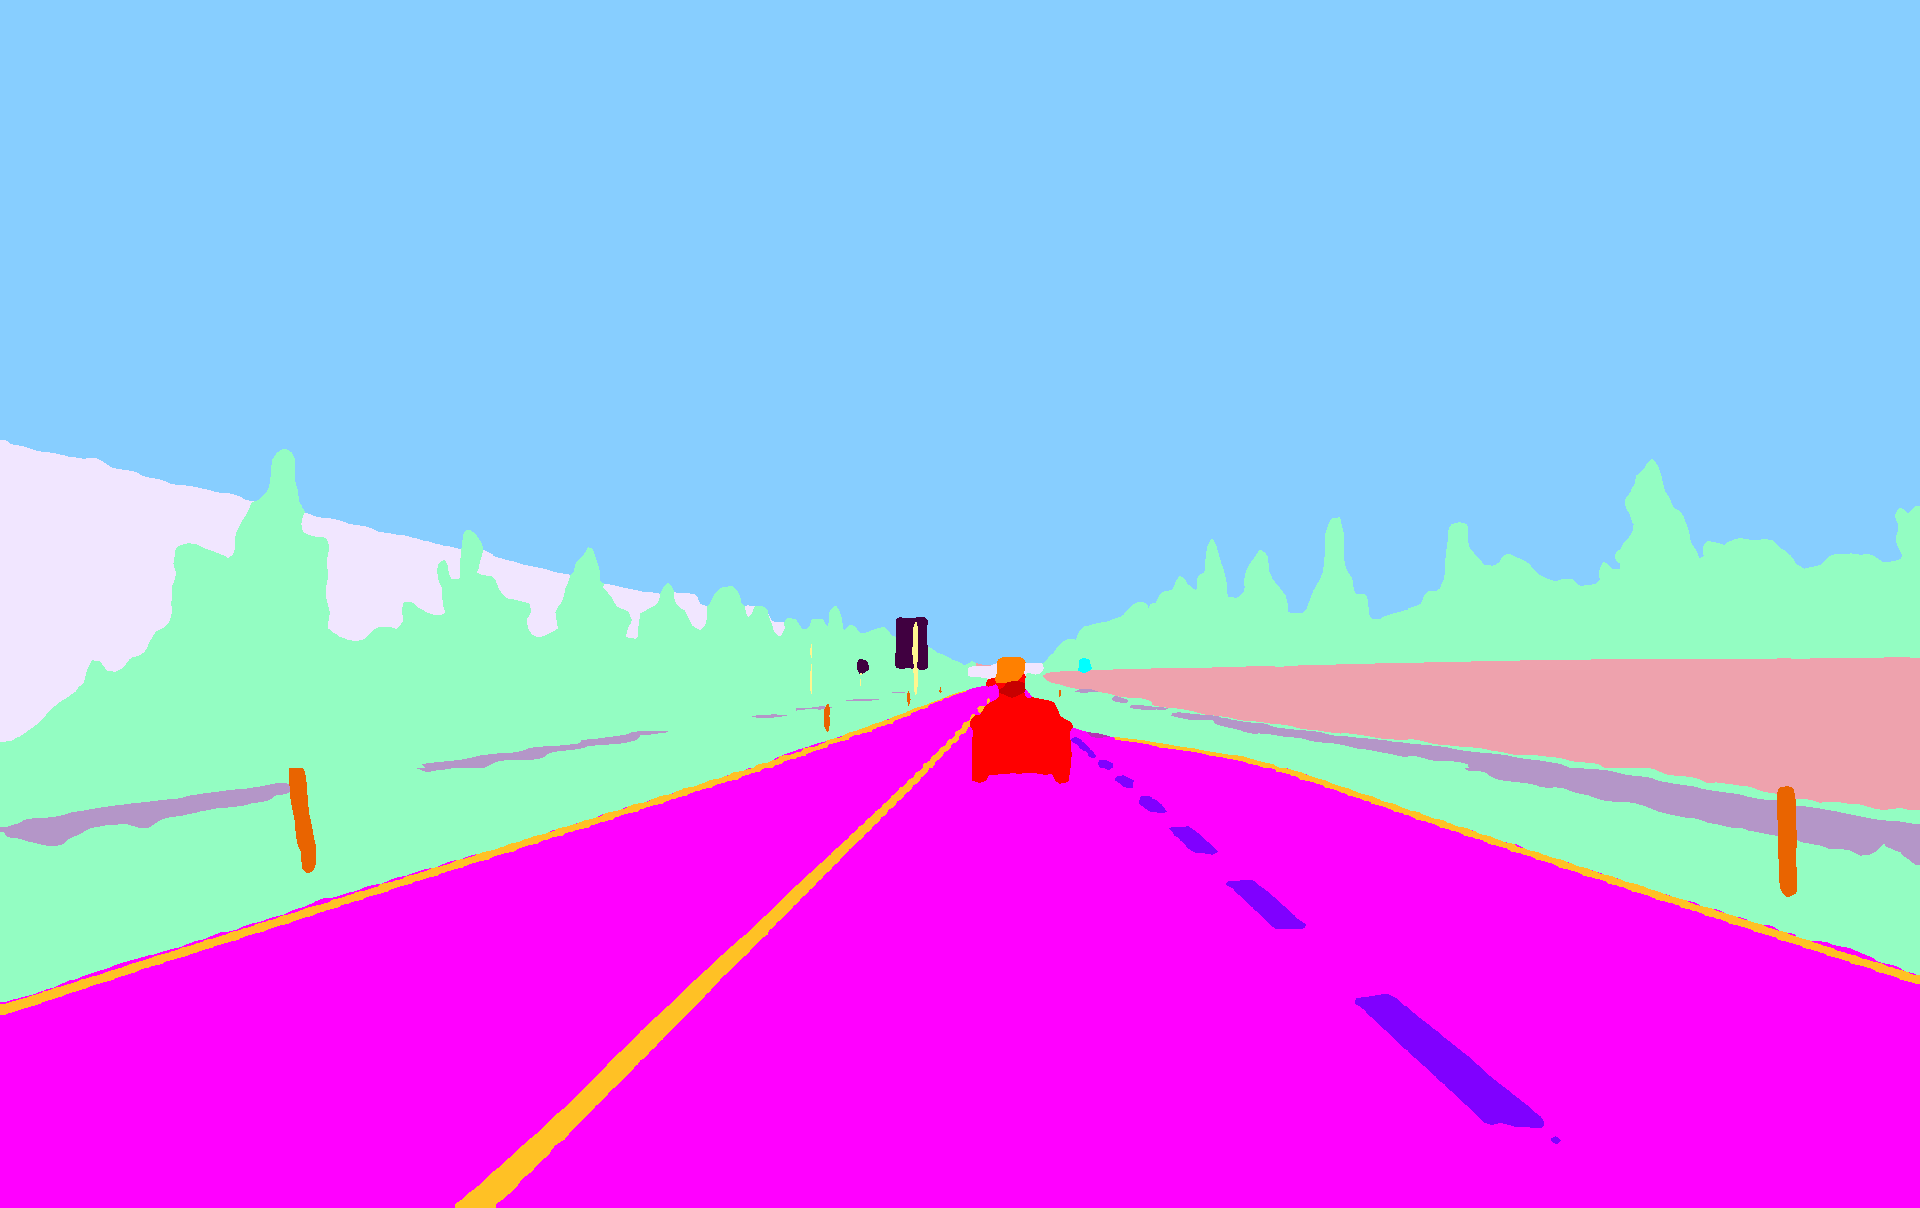

In [ ]:
generate_segmentation_mask_tiled(
    checkpoint_path=".\\model\\resnet50_test_2_new.ckpt",
    input_img_path=".\\test\\test3.png",
    tile_size=(768, 768),
    output_path=".\\test\\test3_new_lr1e-3_out_seg2.png",
    overlap=128
    )

In [ ]:
generate_segmentation_mask(
    checkpoint_path=".\\model\\resnet50_test_2_new.ckpt",
    input_img_path=".\\test\\test.png",
    dataset=dataset
)